In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# HyperParameter

In [2]:
MAX_ElEC = 100.       # 最大电量
ELEC_COST = 0.2      # 单位里程耗电量
ELEC_INIT = 75.       # 初始电量
# CHARGE_TIME  = 0.2 # 充电等待时间
VALUE_TIME  = 0.5    # value of time
SPEED     = 10.       # AVG_SPEED

DISCRETE_NUM = 0
DISCRETE = 10**(-DISCRETE_NUM)

# Prepare

In [3]:
point_group = pd.read_csv("node.csv")

In [4]:
point_group.head()

,point,x,y,charger,price
0,0.0,0.0,0.0,-1.0,0.777063
1,1.0,1.0,0.0,0.0,0.737540
2,2.0,2.0,0.0,0.0,0.883916
3,3.0,3.0,0.0,0.0,0.907396
4,4.0,4.0,0.0,0.0,0.734487


In [5]:
location_matrix = np.array(point_group[['x','y']])
type_column = np.array(point_group['charger']) # 矫正点类型 0-普通点 1-充电桩 -1
charge_price = np.array(point_group['price'])
print(location_matrix.shape[0])
print((type_column!=0).sum())
point_num = location_matrix.shape[0]

91
25


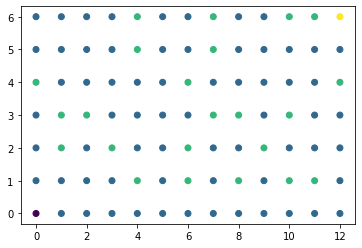

In [6]:
fig = plt.figure()
plt.scatter(location_matrix[:,0],location_matrix[:,1],c=type_column)

## 计算两点间的距离

In [11]:
edge_group = pd.read_csv("edge.csv")

In [12]:
edge_group.head()

,point1,point2,dis
0,0.0,1.0,124.764863
1,0.0,13.0,123.610550
2,1.0,2.0,121.779632
3,1.0,14.0,124.860356
4,2.0,3.0,119.870200


In [13]:
# Initialize
G = nx.Graph()
G.add_nodes_from(np.arange(point_num))
G.add_weighted_edges_from(zip(edge_group.iloc[:,0].apply(int),edge_group.iloc[:,1].apply(int),edge_group.iloc[:,2]))

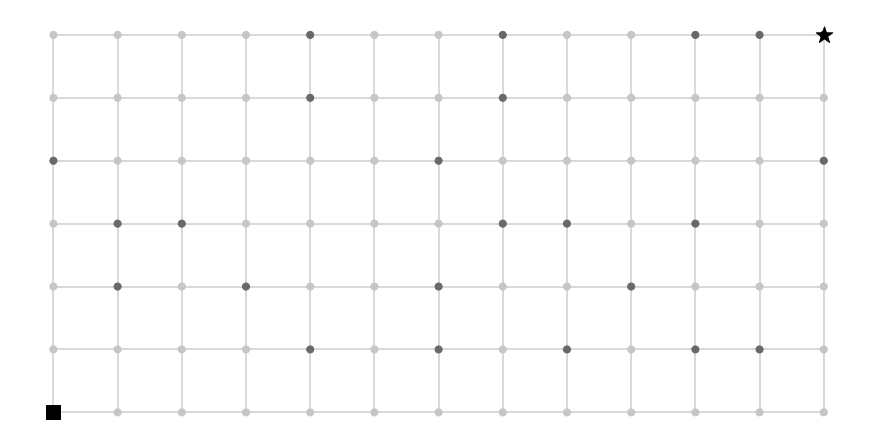

In [14]:
plt.figure(figsize=(12,6))
nx.draw(G,pos=location_matrix,node_size=50,width=0.3,node_color=type_column,cmap=plt.get_cmap('Greys'))
nx.draw_networkx_nodes(G,pos=location_matrix,node_size=200,nodelist=[0],node_color='k',node_shape='s')
nx.draw_networkx_nodes(G,pos=location_matrix,node_size=300,nodelist=[location_matrix.shape[0]-1],node_color='k',node_shape='*')


## 利用最短路修正充电桩之间的距离
distance_matrix = 160*160  (充电桩+起终点）

In [38]:
charger_num = (type_column!=0).sum()
distance_charger = np.zeros((charger_num*charger_num,3))
charger_point = np.arange(point_num)[type_column!=0]
for i in range(charger_point.shape[0]):
    dis_column = nx.shortest_path_length(G,source=charger_point[i],weight='weight')
    for j in range(charger_point.shape[0]):
        cha_index = i*charger_num + j
        distance_charger[cha_index,0] = charger_point[i]
        distance_charger[cha_index,1] = charger_point[j]
        distance_charger[cha_index,2] = dis_column[charger_point[j]]

In [39]:
# 删除路程大于规定值以及0的链接
distance_charger = distance_charger[(distance_charger[:,2]!=0) & (distance_charger[:,2]< MAX_ElEC/ELEC_COST),:]

In [40]:
G_modify = nx.Graph()
G_modify.add_nodes_from(charger_point)
G_modify.add_weighted_edges_from(zip(distance_charger[:,0].astype(np.int),distance_charger[:,1].astype(np.int),distance_charger[:,2]))

In [41]:
_ = nx.shortest_path_length(G_modify,source=0,weight='weight')

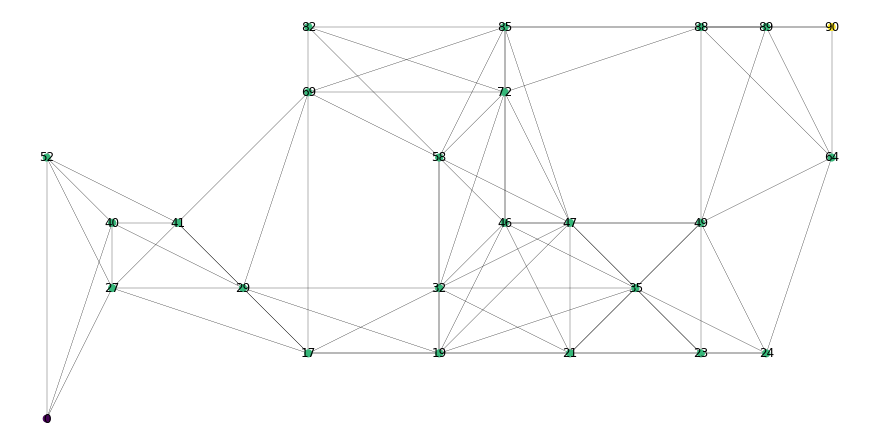

In [42]:
plt.figure(figsize=(12,6))
nx.draw(G_modify,pos=location_matrix,node_size=50,width=0.3,node_color=type_column[type_column!=0],with_labels=True)

# Calculate

In [43]:
def choose_point(state):
    '''
    根据电量允许行驶的里程，求出可能到达的点
    :parameter:
        point: 现在到达的点,
        elc : 剩余电量,
    '''
    p,elc = int(state[0]),state[1]
    global G_modify
    shortest_path = nx.shortest_path_length(G_modify,source=p,weight='weight')
    shortest_path = pd.DataFrame(shortest_path,index=['dis']).T
    shortest_path['point'] = shortest_path.index
    shortest_path.index = np.arange(shortest_path.shape[0])
    shortest_path = shortest_path[shortest_path['dis'] < elc/ELEC_COST]
    return np.array(shortest_path['point'])[1:]

In [67]:
def add_edge(p,elc):
    global ELEC_COST,G_modify,charge_price,DG
    p = int(p)
    ready_point = choose_point(np.array([p,elc]))
    edge_to_add = []
    for point in ready_point:
        if point != charger_point[-1]:
            distance = nx.shortest_path_length(G_modify,source=p,target=point,weight='weight')
            # 不充电的情况
#             cost = distance/SPEED*VALUE_TIME
#             edge_to_add += [('%d,%.2f'%(p,elc),'%d,%.2f'%(point,elc-distance*ELEC_COST),cost)]
            
            elc_min = np.ceil(elc-distance*ELEC_COST)
            new_elc_list = np.arange(elc_min,MAX_ElEC+DISCRETE/10,DISCRETE)
            for new_elc in new_elc_list:
                cost = distance/SPEED*VALUE_TIME + (new_elc-elc_min)*charge_price[int(point)]
                edge_to_add += [('%d,%.2f'%(p,elc),'%d,%.2f'%(point,new_elc),cost)]
        else:
            distance = nx.shortest_path_length(G_modify,source=p,target=point,weight='weight')
            cost = distance/SPEED*VALUE_TIME
            edge_to_add += [('%d,%.2f'%(p,elc),'end',cost)]
    DG.add_weighted_edges_from(edge_to_add)

In [68]:
# Initialize
DG = nx.DiGraph()

for point in charger_point[1:-1]:
    print(point)
    for elc in np.arange(0,MAX_ElEC+DISCRETE/10,DISCRETE):
        add_edge(point,elc)

add_edge(charger_point[0],ELEC_INIT)

# for elc in np.arange(0,MAX_ElEC+DISCRETE/10,DISCRETE):
#     DG.add_edge('%d,%.2f'%(charger_point[-1],elc),'end')

17
19
21
23
24
27
29
32
35
40
41
46
47
49
52
58
64
69
72
82
85
88
89


In [69]:
short_path = nx.shortest_path(DG,source='%d,%.2f'%(0,ELEC_INIT),target='end',weight='weight') # 
print(nx.shortest_path_length(DG,source='%d,%.2f'%(0,ELEC_INIT),target='end',weight='weight'))

317.01238627410544


# 可视化

In [70]:
short_path

['0,75.00',
 '27,100.00',
 '40,100.00',
 '41,94.00',
 '69,23.00',
 '82,73.00',
 '85,95.00',
 '88,24.00',
 '89,25.00',
 'end']

In [71]:
def draw_shortest_path(short_path):
    global G
    G_plot = nx.Graph()
    point_list = np.array([point.split(',')[0] for point in short_path][:-1]+[charger_point[-1]]).astype(np.int)
    for i in range(point_list.shape[0]-1):
        short_sub = nx.shortest_path(G,source=point_list[i],target=point_list[i+1],weight='weight')
        for j in range(len(short_sub)-1):
            G_plot.add_edge(short_sub[j],short_sub[j+1])
    return G_plot

In [72]:
G_plot = draw_shortest_path(short_path)

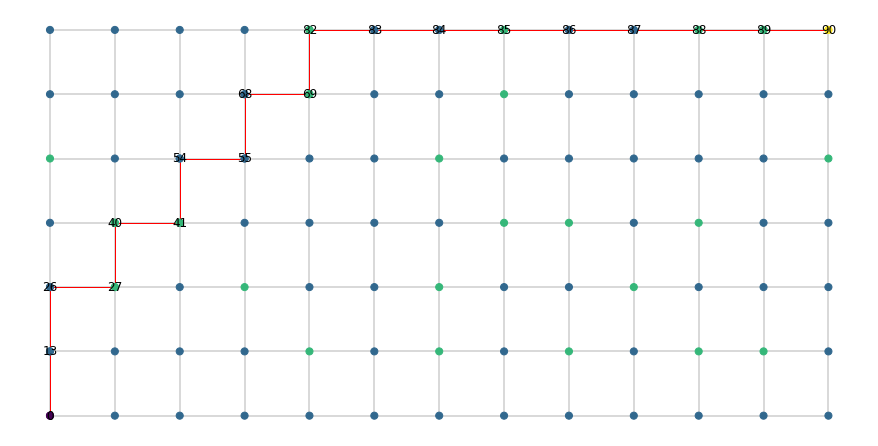

In [73]:
plt.figure(figsize=(12,6))
nx.draw(G,pos=location_matrix,node_size=50,width=0.3,node_color=type_column)
nx.draw(G_plot,pos=location_matrix,node_size=50,width=1,edge_color='r',node_color=type_column[np.array(G_plot.nodes)],with_labels=True) #